## PCA with a linear Autoencoder

In [4]:
import numpy.random as rnd
import numpy as np

rnd.seed(4)
m = 200
w1, w2= 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m,3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) /2
data[:, 2] = data[:, 0] * w1 + data[:,1] * w2 + noise * rnd.randn(m)

In [5]:
# normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [6]:
# plt.plot(X_train[:,0], X_train[:,1], X_train[:,2], "b.")
# #plt.plot(X_train[:,1], X_train[:,2], "g.")
# plt.plot(X_train[:,0], X_train[:,1], "r.")
# plt.show()
# # looking at the dataset
# plt.plot(X_train[:,0], X_train[:,1], "r.")
# plt.show()

In [7]:
# building the autoencoder
import tensorflow as tf

tf.reset_default_graph()
np.random.seed(42)

n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D inputs
n_outputs = n_inputs # condition for autoencoders

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None,n_inputs])
hidden = tf.layers.dense(X, n_hidden) 
# dense is equivalent of fully connected
# needs no activation for PCA
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

W0623 06:36:35.917317   888 deprecation.py:323] From <ipython-input-7-e7f97946e267>:14: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0623 06:36:35.925356   888 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


In [8]:
n_iterations = 1000
codings = hidden
# the output of hidden layer provides the codings

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X:X_train}) # no labesl given
    codings_val = codings.eval(feed_dict={X:X_test})

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1],"b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$",fontsize=18, rotation=0)
plt.show()

<Figure size 400x300 with 1 Axes>

## stacked autoencoder

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data")

W0624 10:04:49.283727  8108 deprecation.py:323] From <ipython-input-7-7187608d1af6>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0624 10:04:49.284724  8108 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0624 10:04:49.285720  8108 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instruc

Extracting /tmp/data\train-images-idx3-ubyte.gz


W0624 10:04:49.493166  8108 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0624 10:04:49.543031  8108 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting /tmp/data\train-labels-idx1-ubyte.gz
Extracting /tmp/data\t10k-images-idx3-ubyte.gz
Extracting /tmp/data\t10k-labels-idx1-ubyte.gz


## Training all layers at once


In [11]:
# we will build a stacked Autoencoder with 3 hidden layers 
# and one output layer
# we will use ELU activation, He initialisation and L2 regularisation

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

from functools import  partial

n_inputs = 28 * 28 # for mnist
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate =0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32,shape=[None, n_inputs])
he_init = tf.contrib.layers.variance_scaling_initializer()
# He initialization

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
# l2 regularizar

my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu, #elu activation
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

# partial is agood way to define layers
# keras shold have something like this

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1,n_hidden2) # codings
hidden3 = my_dense_layer(hidden2,n_hidden3)
outputs = my_dense_layer(hidden3,n_outputs, activation=None) # no activation in output

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
# mSE

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss =tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()


W0623 06:36:57.435705   888 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [12]:
# training
# this is unsupervised as we not feeding y_batch
import os

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches),end= "")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})#no y_batch
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layer.ckpt")

09% Train MSE: 0.020754643
1 Train MSE: 0.011403462
2 Train MSE: 0.01021647
3 Train MSE: 0.009904613
4 Train MSE: 0.010381779


In [15]:
def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")

In [13]:
def plot_multiple_images(images,n_roes, n_cols, pad=2):
    images = images - images.min() 
    # making the minimum look zero so that the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w + pad) * n_rows + pad, (h + pad)* n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y * (h + pad) + pad): (y * (h + pad) + pad + h), (x * (w + pad) + pad):(x * (w + pad) + pad + w)] = images[y * n_cols + x]
        plt.imshow(image, cmap="Greys", interpolation="nearest")
    

In [14]:
def show_reconstructed_digits(X, outputs, model_path=None,n_test_digits=2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X:X_test})
    
    fig = plt.figure(figsize=(8,3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2+ 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

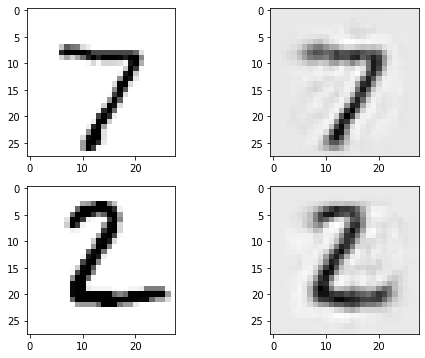

In [16]:
show_reconstructed_digits(X, outputs, "./my_model_all_layer.ckpt")

## Tying wieghts

In [17]:
# its common to tie the weights of encoder and decoder, but ut makes very difficult to use tf.layer.dense
# so we build the autoencoder manually

tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1= 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [18]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1,n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3") # tied weights
# these are not varibales
weights4 = tf.transpose(weights1, name="weights4") # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4") 
# biases are not tied for weights 3 and weights 4

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
# we donst regularize weights3 and weights4
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [19]:
saver = tf.train.Saver()

In [20]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_trying_weights.ckpt")

0 Train MSE: 0.015868127
1 Train MSE: 0.015834728
2 Train MSE: 0.017224913
3 Train MSE: 0.017376056
4 Train MSE: 0.017070267


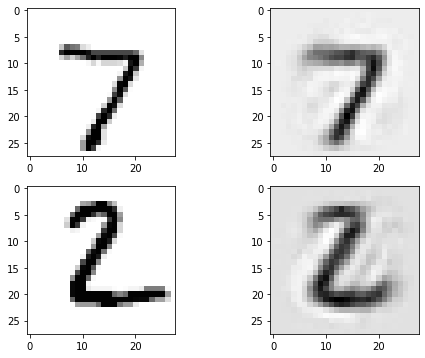

In [21]:
show_reconstructed_digits(X, outputs, "./my_model_trying_weights.ckpt")

## training one autoencoder at a time in multiple graphs

In [22]:
# the idea is to train the autoencoders seperately 
# and then using stacked autoencoder by simply initiaising it with copied weights

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg= 0.0005, seed=42,
                      hidden_activation= tf.nn.elu,
                      output_activation= tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        n_inputs = X_train.shape[1]
        X = tf.placeholder(tf.float32,shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
        )
        
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches),end="")
                os.sys.stdout.flush()
                indices= rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X:X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X:X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
    

In [23]:
# training two autoencoders

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300,n_epochs=4, batch_size=150, output_activation=None )
_, W2 , b2 , W3,b3 = train_autoencoder(hidden_output, n_neurons=150,n_epochs=4, batch_size=150)

09% Train MSE: 0.018122243
1 Train MSE: 0.018951437
2 Train MSE: 0.019684358
3 Train MSE: 0.019918667
0 Train MSE: 0.004308575
1 Train MSE: 0.0044467817
2 Train MSE: 0.0045360164
39% Train MSE: 0.004557439


In [24]:
# finally we create a stacked autoencoder by simply reusing the weights and biases
# from the autoencoders we just trained

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None,n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

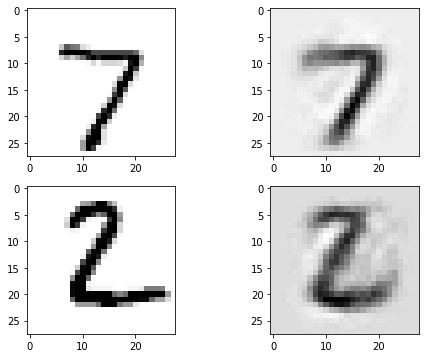

In [25]:
show_reconstructed_digits(X, outputs)

## Training one encoder at a time using a single graph

In [35]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32,shape=[None,n_inputs])

weights1_init = initializer([n_inputs,n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2,n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1 ))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss,var_list=train_vars) # freexe hidden1

In [37]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [39]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4,4]
batch_sizes = [150,150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase +1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration //n_batches),end="" )
                os.sys.stdout.flush()
                X_batch,y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X:X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X:X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time2.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X:mnist.test.images})
        print("test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.00781542
1 Train MSE: 0.0076973666
2 Train MSE: 0.007350235
3 Train MSE: 0.007995839
test MSE: 0.10658554
Training phase #2
09% Train MSE: 0.15582371
1 Train MSE: 0.004121725
2 Train MSE: 0.002279228
3 Train MSE: 0.0019214792
test MSE: 0.009613337


In [40]:
### Cache the frozen layer outputs

training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150,150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X:mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r()%".format(100 * iteration // n_batches),end="" )
                os.sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase],feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:",loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
        loss_test = reconstruction_loss.eval(feed_dict={X:mnist.test.images})
        print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007822849
1 Train MSE: 0.007664169
2 Train MSE: 0.007548139
3 Train MSE: 0.007860314
Test MSE: 0.10571653
Training phase #2
0 Train MSE: 0.16723849
1 Train MSE: 0.0044513075
2 Train MSE: 0.0023131466
3 Train MSE: 0.0019665223
Test MSE: 0.009740664


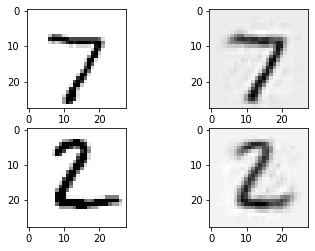

In [41]:
# visualising the reconnstruction

n_test_digits =2
X_test =mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time2.ckpt")
    # not shown in the book
    outputs_val = outputs.eval(feed_dict={X:X_test})

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

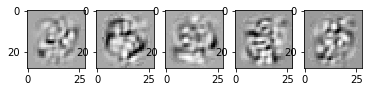

In [42]:
# visualizing the extracted features

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time2.ckpt")
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1,5,i+ 1)
    plot_image(weights1_val.T[i])

plt.show()

## Unsupervised pretraining

In [47]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)


n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs =10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None,n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init,dtype=tf.float32,name="weights1")
weights2 = tf.Variable(weights2_init,dtype=tf.float32,name="weights2")
weights3 = tf.Variable(weights3_init,dtype=tf.float32,name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2,weights3) + biases3 # logits

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [48]:
# regular training without pretraining

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration //n_batches), end="")
            os.sys.stdout.flush()
            indices= rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        print("\r{}".format(epoch), "Train accuracy: ", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval (feed_dict={X:mnist.test.images,y:mnist.test.labels})
        print("Test accuracy: ", accuracy_val)
    

09% Train accuracy:  0.9533333 Test accuracy:  0.9371
1 Train accuracy:  0.97333336 Test accuracy:  0.9278
2 Train accuracy:  0.96 Test accuracy:  0.9227
3 Train accuracy:  0.9533333 Test accuracy:  0.9482


In [50]:
#now reusing the first two layers of autoencoder we pretrained

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration //n_batches),end = "")
            os.sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
        accuracy_val = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X:mnist.test.images, y:mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.96	Test accuracy: 0.9185
1 Train accuracy: 0.97333336	Test accuracy: 0.9444
2 Train accuracy: 0.97333336	Test accuracy: 0.9359
3 Train accuracy: 0.98	Test accuracy: 0.9497


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(2, 10)


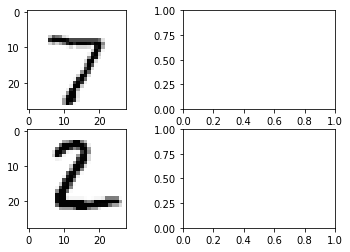

In [58]:
#  visualizing

n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

print(X_test)
with tf.Session() as sess:
    saver.restore(sess,"./my_model_supervised_pretrained.ckpt")
    outputs_val = logits.eval(feed_dict={X:X_test})

print(outputs_val.shape)
# plotting graph
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    #plot_image(outputs_val[digit_index])
    #shape (2,10) cannot be resized

In [ ]:
show_reconstructed_digits(X, logits, "./my_model_supervised_pretrained.ckpt")

## stacked denoising autoencoder

In [2]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2  = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [4]:
noise_level = 1.0
X = tf.placeholder(tf.float32,shape=[None,n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))
hidden1 = tf.layers.dense(X_noisy,n_hidden1,activation=tf.nn.elu, name="hidden1")
hidden2 = tf.layers.dense(hidden1,n_hidden2,activation=tf.nn.elu,name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.elu,name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs -X))
                                                                                                                                                                                                                                              

W0624 06:39:11.959638 13452 deprecation.py:323] From <ipython-input-4-f6dc3e1d1aa3>:4: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.
W0624 06:39:11.960655 13452 deprecation.py:323] From C:\installs\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow_core\python\layers\core.py:187: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


In [5]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
import os 

n_epochs = 10
batch_size =150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches))
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0%
0%
0%
0%
1%
1%
1%
1%
2%
2%
2%
3%
3%
3%
3%
4%
4%
4%
4%
5%
5%
5%
6%
6%
6%
6%
7%
7%
7%
7%
8%
8%
8%
9%
9%
9%
9%
10%
10%
10%
10%
11%
11%
11%
12%
12%
12%
12%
13%
13%
13%
13%
14%
14%
14%
15%
15%
15%
15%
16%
16%
16%
16%
17%
17%
17%
18%
18%
18%
18%
19%
19%
19%
19%
20%
20%
20%
21%
21%
21%
21%
22%
22%
22%
22%
23%
23%
23%
24%
24%
24%
24%
25%
25%
25%
25%
26%
26%
26%
27%
27%
27%
27%
28%
28%
28%
28%
29%
29%
29%
30%
30%
30%
30%
31%
31%
31%
31%
32%
32%
32%
33%
33%
33%
33%
34%
34%
34%
34%
35%
35%
35%
36%
36%
36%
36%
37%
37%
37%
37%
38%
38%
38%
39%
39%
39%
39%
40%
40%
40%
40%
41%
41%
41%
42%
42%
42%
42%
43%
43%
43%
43%
44%
44%
44%
45%
45%
45%
45%
46%
46%
46%
46%
47%
47%
47%
48%
48%
48%
48%
49%
49%
49%
50%
50%
50%
50%
51%
51%
51%
51%
52%
52%
52%
53%
53%
53%
53%
54%
54%
54%
54%
55%
55%
55%
56%
56%
56%
56%
57%
57%
57%
57%
58%
58%
58%
59%
59%
59%
59%
60%
60%
60%
60%
61%
61%
61%
62%
62%
62%
62%
63%
63%
63%
63%
64%
64%
64%
65%
65%
65%
65%
66%
66%
66%
66%
67%
67%
67%
68%
68%
68%
68%
69%
69%
69%
69%
70%
70%
7

66%
66%
66%
67%
67%
67%
68%
68%
68%
68%
69%
69%
69%
69%
70%
70%
70%
71%
71%
71%
71%
72%
72%
72%
72%
73%
73%
73%
74%
74%
74%
74%
75%
75%
75%
75%
76%
76%
76%
77%
77%
77%
77%
78%
78%
78%
78%
79%
79%
79%
80%
80%
80%
80%
81%
81%
81%
81%
82%
82%
82%
83%
83%
83%
83%
84%
84%
84%
84%
85%
85%
85%
86%
86%
86%
86%
87%
87%
87%
87%
88%
88%
88%
89%
89%
89%
89%
90%
90%
90%
90%
91%
91%
91%
92%
92%
92%
92%
93%
93%
93%
93%
94%
94%
94%
95%
95%
95%
95%
96%
96%
96%
96%
97%
97%
97%
98%
98%
98%
98%
99%
99%
99%
5 Train MSE: 0.04123614
0%
0%
0%
0%
1%
1%
1%
1%
2%
2%
2%
3%
3%
3%
3%
4%
4%
4%
4%
5%
5%
5%
6%
6%
6%
6%
7%
7%
7%
7%
8%
8%
8%
9%
9%
9%
9%
10%
10%
10%
10%
11%
11%
11%
12%
12%
12%
12%
13%
13%
13%
13%
14%
14%
14%
15%
15%
15%
15%
16%
16%
16%
16%
17%
17%
17%
18%
18%
18%
18%
19%
19%
19%
19%
20%
20%
20%
21%
21%
21%
21%
22%
22%
22%
22%
23%
23%
23%
24%
24%
24%
24%
25%
25%
25%
25%
26%
26%
26%
27%
27%
27%
27%
28%
28%
28%
28%
29%
29%
29%
30%
30%
30%
30%
31%
31%
31%
31%
32%
32%
32%
33%
33%
33%
33%
34%
34%
34%
34%
35%
3

## using dropout

In [8]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(32)

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [9]:
dropout_rate = 0.3
training = tf.placeholder_with_default(False, shape=(), name='training')
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X,dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation = tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation= tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")

outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

W0624 07:09:54.370400 13452 deprecation.py:323] From <ipython-input-9-6bac8c6e87bb>:4: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [10]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [13]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X:X_batch, training:True})
        loss_train = reconstruction_loss.eval(feed_dict={X:X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

09% Train MSE: 0.028325787
19% Train MSE: 0.026456136
2 Train MSE: 0.024621012
3 Train MSE: 0.026148105
4 Train MSE: 0.02402459
5 Train MSE: 0.02298263
6 Train MSE: 0.024797613
7 Train MSE: 0.023606094
89% Train MSE: 0.02274525
9 Train MSE: 0.023427702


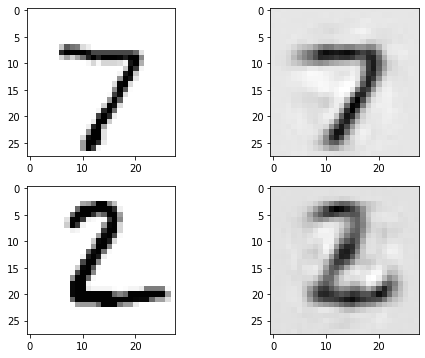

In [20]:
import matplotlib.pyplot as plt
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## sparse autoencoder

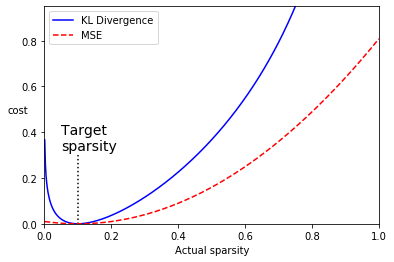

In [22]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q))
mse = (p-q)**2
plt.plot([p,p], [0,0.3], "k:")
plt.text(0.05, 0.32,"Target\nsparsity", fontsize=14)
plt.plot(q,kl_div, "b-",label="KL Divergence")
plt.plot(q, mse,"r--",label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("cost",rotation=0)
plt.axis([0,1,0,0.95])
plt.show()

In [30]:
import tensorflow as tf
import numpy as np

tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

n_inputs = 28 * 28
n_hidden1 = 1000
n_outputs = n_inputs

In [31]:
def kl_divergence(p,q):
    return p * tf.log(p/q) + (1-p) * tf.log((1-p)/ (1-q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden1 = tf.layers.dense(X, n_hidden1,activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target,hidden1_mean ))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)


In [32]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
n_epochs = 100
batch_size = 1000

import os

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            os.sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict ={X:X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss],feed_dict={X:X_batch} )
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

08% Train MSE: 0.12811789 	Sparsity loss: 0.39608312 	Total loss: 0.20733452
1 Train MSE: 0.05918792 	Sparsity loss: 0.016865652 	Total loss: 0.06256105
2 Train MSE: 0.05288915 	Sparsity loss: 0.016504988 	Total loss: 0.056190148
3 Train MSE: 0.047796506 	Sparsity loss: 0.0585783 	Total loss: 0.05951217
4 Train MSE: 0.043276638 	Sparsity loss: 0.2943919 	Total loss: 0.102155015
5 Train MSE: 0.041584633 	Sparsity loss: 0.07117383 	Total loss: 0.0558194
6 Train MSE: 0.038342364 	Sparsity loss: 0.055093188 	Total loss: 0.049361
7 Train MSE: 0.03512397 	Sparsity loss: 0.1941767 	Total loss: 0.07395931
8 Train MSE: 0.033335794 	Sparsity loss: 0.031001572 	Total loss: 0.039536107
9 Train MSE: 0.028976938 	Sparsity loss: 0.023690822 	Total loss: 0.033715103
10% Train MSE: 0.02660625 	Sparsity loss: 0.018471437 	Total loss: 0.030300537
11 Train MSE: 0.025258152 	Sparsity loss: 0.036241468 	Total loss: 0.032506444
12 Train MSE: 0.023420338 	Sparsity loss: 0.014249339 	Total loss: 0.026270205
13

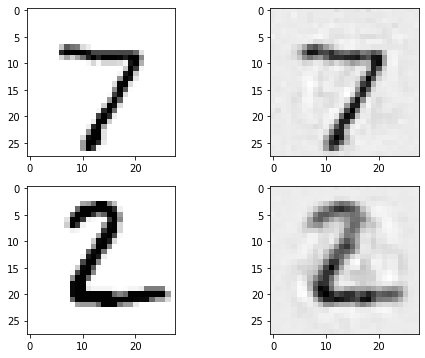

In [34]:
import matplotlib.pyplot as plt
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

In [27]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

In [28]:
# we can speed up training by using inputs between 0 and 1 and use the 
# cross_entropy instead of the MSE for the cost function

logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits )
reconstruction_loss = tf.reduce_mean(xentropy)

## Variational autoencoder

In [38]:
tf.reset_default_graph()
tf.set_random_seed(42)
np.random.seed(42)

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

W0624 11:25:03.397952  8108 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [41]:
eps = 1e-10
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean) 
    - 1- tf.log(eps + tf.square(hidden3_sigma))
)

In [50]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate =learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [54]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            os.sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 31272.887 	Reconstruction loss: 24983.674 	Latent loss: 6289.212
1 Train total loss: 35291.28 	Reconstruction loss: 26787.102 	Latent loss: 8504.179
2 Train total loss: 28932.648 	Reconstruction loss: 24003.088 	Latent loss: 4929.56
3 Train total loss: 27907.98 	Reconstruction loss: 23005.05 	Latent loss: 4902.929
4 Train total loss: 24345.832 	Reconstruction loss: 19686.805 	Latent loss: 4659.027
5 Train total loss: 19544.924 	Reconstruction loss: 16504.846 	Latent loss: 3040.0786
6 Train total loss: 21908.469 	Reconstruction loss: 18378.217 	Latent loss: 3530.2517
79% Train total loss: 18738.988 	Reconstruction loss: 15670.979 	Latent loss: 3068.009
8 Train total loss: 17176.182 	Reconstruction loss: 14047.349 	Latent loss: 3128.833
9 Train total loss: 17165.645 	Reconstruction loss: 13894.221 	Latent loss: 3271.4238
10 Train total loss: 16224.238 	Reconstruction loss: 13170.801 	Latent loss: 3053.4377
11 Train total loss: 21617.016 	Reconstruction loss: 17685.969

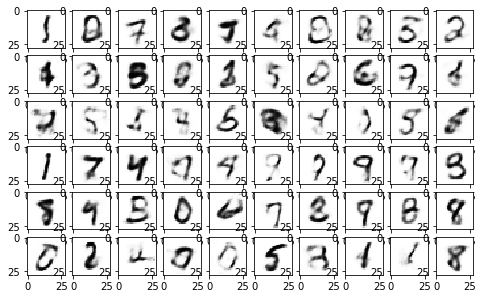

In [58]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.grid(False)
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

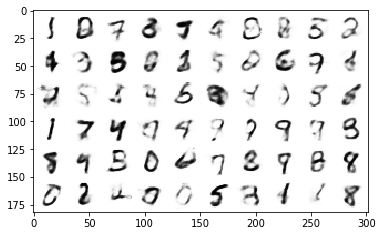

In [59]:
# another wat to genrate thorugh plot_multiple_images
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28,28), n_rows, n_cols)
plt.show()

In [61]:
# # another way to define latent loss
# latent_loss = 0.5 * tf.reduce_sum(
# tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

# Encoding and decoding

In [62]:
# encoding
n_digits = 3
X_test,y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X:X_test})

In [63]:
# decoding
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings:codings_val})

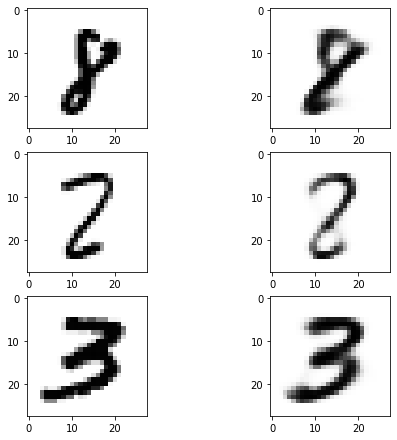

In [65]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))

for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

## Interpolating digits

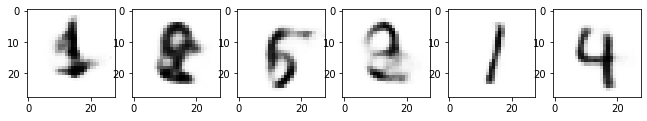

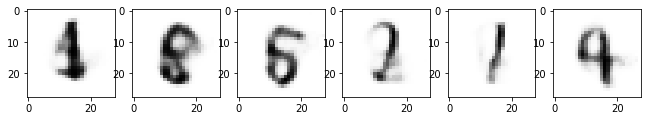

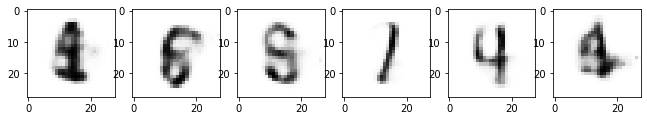

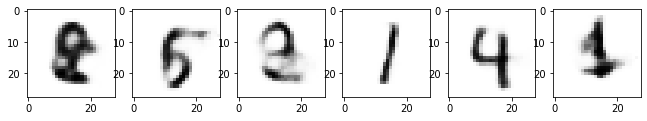

In [67]:
n_iterations =3
n_digits =6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings -codings_rnd) * iteration /n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5 * n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()